In [1]:
from pathlib import Path

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import fiona
from shapely.geometry import box
import matplotlib.pyplot as plt
import contextily as cx
import zarr

import hydromt
from hydromt_sfincs import SfincsModel
from hydromt_sfincs import utils

### Obtaining Data

In [2]:
huc_8 = "11070103"
base_data_path = Path("/Users/taddbindas/projects/hydromt_sfincs/examples/tmp_ngwpc_data")
output_geojson = base_data_path / f"output_{huc_8}.geojson"
huc8_data = base_data_path / "huc8s_sp.gpkg"
gdf = gpd.read_file(huc8_data)
subset  = gdf[gdf["HUC8"] == huc_8]
# subset.to_file(output_geojson, driver='GeoJSON')
subset

,HUC8,median_slope,missing_median_slope,freq_high_dev,missing_freq_high_dev,percent_covered_by_tiles,geometry
811,11070103,0.018635,False,0.001553,False,93.398251,"MULTIPOLYGON (((48445.25 1602684.982, 48469.97..."


In [3]:
huc8_data = base_data_path / "nws_lid.gpkg"
ahps_gdf = gpd.read_file(huc8_data)
ahps_subset = ahps_gdf[ahps_gdf["HUC8"] == huc_8]
ahps_subset

,nwm_feature_id,nws_lid,usgs_site_code,HUC8,name,states,is_headwater,is_colocated,geometry
2072,21797175,CFVK1,None,11070103,Middle Verdigris,"KS,OK",0,0,POINT (32153.227 1557702.444)
2073,21796329,IDPK1,07170500,11070103,Middle Verdigris,"KS,OK",0,0,POINT (28324.056 1575868.523)
2074,21798265,LEPO2,07171000,11070103,Middle Verdigris,"KS,OK",0,0,POINT (36563.201 1534163.039)


In [4]:
rfc_loc = "CFVK1"
ahps_lid = ahps_subset[ahps_subset["nws_lid"] == rfc_loc]   

In [5]:
conus_df = pd.read_parquet("/Users/taddbindas/hydrofabric/v20.1/conus_net.parquet")
filtered_df = conus_df[~pd.isna(conus_df['hl_uri'])]
conus_df.head()

,id,toid,divide_id,ds_id,mainstem,hl_id,hydroseq,hl_uri,hf_source,hf_id,lengthkm,areasqkm,tot_drainage_areasqkm,type,vpu,hf_areasqkm,hf_hydroseq
0,wb-280,tnx-1000000569,cat-280,NaN,1780414.0,01236,18917.0,HUC12-010100100101,NHDPlusV2,816563.0,5.135779,13.281300,51.687449,terminal,01,9.3258,2243683.0
1,wb-280,tnx-1000000569,cat-280,NaN,1780414.0,01236,18917.0,HUC12-010100100101,NHDPlusV2,816417.0,5.135779,13.281300,51.687449,terminal,01,1.9071,2243682.0
2,wb-280,tnx-1000000569,cat-280,NaN,1780414.0,01236,18917.0,HUC12-010100100101,NHDPlusV2,816415.0,5.135779,13.281300,51.687449,terminal,01,2.0484,2243689.0
3,wb-433,tnx-1000000056,cat-433,NaN,1780852.0,01244,18823.0,HUC12-010100110104,NHDPlusV2,818615.0,6.080505,8.605801,22.284001,terminal,01,7.0902,2244228.0
4,wb-433,tnx-1000000056,cat-433,NaN,1780852.0,01244,18823.0,HUC12-010100110104,NHDPlusV2,818525.0,6.080505,8.605801,22.284001,terminal,01,1.5111,2244227.0


In [6]:
# def find_location(loc_id: str) -> int:
#     location = filtered_df[filtered_df['hl_uri'].str.contains(loc_id)].iloc[-1]["hf_id"]
#     return location

rfc_loc = "CFVK1"
# comid_upstream = find_location(rfc_loc)

usgs_gage = "07171000"
filtered_df[filtered_df['hl_uri'].str.contains(usgs_gage)]
# comid_downstream = find_location(usgs_gage)
# print(f"RFC COMID upstream = {comid_upstream}, RFC COMID downstream = {comid_downstream}")

,id,toid,divide_id,ds_id,mainstem,hl_id,hydroseq,hl_uri,hf_source,hf_id,lengthkm,areasqkm,tot_drainage_areasqkm,type,vpu,hf_areasqkm,hf_hydroseq
2012331,wb-2175886,nex-2175887,cat-2175886,NaN,608934.0,111670,13821.0,Gages-07171000,NHDPlusV2,21798219.0,7.030249,9.443250,9281.407675,nexus,11,0.1827,339633.0
2012332,wb-2175886,nex-2175887,cat-2175886,NaN,608934.0,111670,13821.0,Gages-07171000,NHDPlusV2,21798233.0,7.030249,9.443250,9281.407675,nexus,11,7.2054,339520.0
2012333,wb-2175886,nex-2175887,cat-2175886,NaN,608934.0,111670,13821.0,Gages-07171000,NHDPlusV2,21798265.0,7.030249,9.443250,9281.407675,nexus,11,2.6973,339408.0
2142408,wb-2176967,nex-2175887,cat-2176967,NaN,612271.0,111670,13819.0,Gages-07171000,NHDPlusV2,21798527.0,6.026771,8.792099,8.792100,nexus,11,8.8056,1018327.0
2142409,wb-2176966,nex-2175887,cat-2176966,NaN,612269.0,111670,13820.0,Gages-07171000,NHDPlusV2,21798529.0,7.777258,14.992649,14.992650,nexus,11,14.9751,1018783.0


In [7]:
rfc_loc = "CFVK1"
filtered_df[filtered_df['hl_uri'].str.contains(rfc_loc)]

,id,toid,divide_id,ds_id,mainstem,hl_id,hydroseq,hl_uri,hf_source,hf_id,lengthkm,areasqkm,tot_drainage_areasqkm,type,vpu,hf_areasqkm,hf_hydroseq
2014022,wb-2177031,nex-2177032,cat-2177031,NaN,612479.0,11710,13692.0,AHPS-CFVK1,NHDPlusV2,21797123.0,8.243834,7.8741,7.874099,nexus,11,5.4495,341553.0
2014023,wb-2177031,nex-2177032,cat-2177031,NaN,612479.0,11710,13692.0,AHPS-CFVK1,NHDPlusV2,21797175.0,8.243834,7.8741,7.874099,nexus,11,0.5877,341424.0
2014024,wb-2177031,nex-2177032,cat-2177031,NaN,612479.0,11710,13692.0,AHPS-CFVK1,NHDPlusV2,21797125.0,8.243834,7.8741,7.874099,nexus,11,1.8621,1018400.0


In [8]:
import networkx as nx
gpkg = "/Users/taddbindas/hydrofabric/v20.1/gpkg/nextgen_11.gpkg"
flowlines = gpd.read_file(gpkg, layer="flowpaths")
nexus = gpd.read_file(gpkg, layer="nexus")
divides = gpd.read_file(gpkg, layer="divides")
flowpath_attributes = gpd.read_file(gpkg, layer="flowpath_attributes")


In [9]:
# import matplotlib.pyplot as plt
# import contextily as cx

# fig, ax = plt.subplots(figsize=(10, 10))

# # Plot the original data
# flowlines.plot(ax=ax, alpha=0.5)

# cx.add_basemap(ax, crs=flowlines.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

# # Set the title and remove axis
# plt.title('Plotting the sample network')
# ax.axis('off')

# # Display the plot
# plt.tight_layout()
# plt.show()

In [10]:
G = nx.DiGraph()
nexus_to_toid = dict(zip(nexus['id'], nexus['toid']))
for _, node in nexus.iterrows():
    G.add_node(node['id'], 
               type=node['type'], 
               geometry=node['geometry'],
               toid=node['toid'])

for _, edge in flowlines.iterrows():
    G.add_edge(edge['id'], edge['toid'], 
               mainstem=edge['mainstem'],
               order=edge['order'],
               hydroseq=edge['hydroseq'],
               lengthkm=edge['lengthkm'],
               areasqkm=edge['areasqkm'],
               tot_drainage_areasqkm=edge['tot_drainage_areasqkm'],
               has_divide=edge['has_divide'],
               divide_id=edge['divide_id'],
               geometry=edge['geometry'])
    
    if edge['toid'] in nexus_to_toid:
        G.add_edge(edge['toid'], nexus_to_toid[edge['toid']])



# Print some basic information about the graph
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Example of accessing node attributes
print("\nExample node attributes:")
example_node = list(G.nodes())[0]
print(f"Attributes of node {example_node}:")
print(G.nodes[example_node])

# Example of accessing edge
print("\nExample edge:")
example_edge = list(G.edges())[0]
print(f"Edge: {example_edge}")

Number of nodes: 92211
Number of edges: 92156

Example node attributes:
Attributes of node nex-1000006131:
{'type': 'nexus', 'geometry': <POINT (-411313.625 1707430.743)>, 'toid': 'wb-1000006131'}

Example edge:
Edge: ('nex-1000006131', 'wb-1000006131')


In [11]:
start_node = "nex-2177032"
end_node = "nex-2175887"
path = nx.shortest_path(G, start_node, end_node)
# descendants = set(nx.descendants(G, start_node))
path

['nex-2177032',
 'wb-2177032',
 'nex-2175879',
 'wb-2175879',
 'nex-2175880',
 'wb-2175880',
 'nex-2175881',
 'wb-2175881',
 'nex-2175882',
 'wb-2175882',
 'nex-2175883',
 'wb-2175883',
 'nex-2175884',
 'wb-2175884',
 'nex-2175885',
 'wb-2175885',
 'nex-2175886',
 'wb-2175886',
 'nex-2175887']

In [12]:
mask_flowlines = flowlines["id"].isin(path) | flowlines["toid"].isin(path)
mask_nexus = nexus["id"].isin(path)
mask_divides = divides["id"].isin(path)

_subset_nexus = nexus[mask_nexus]
_subset_flowlines = flowlines[mask_flowlines]
_subset_divides = divides[mask_divides]

In [13]:
boundaries_file = "/Users/taddbindas/projects/hydromt_sfincs/examples/tmp_ngwpc_data/boundaries.geojson"
boundaries = _subset_nexus[_subset_nexus["id"].isin([path[0], path[-1]])]
boundaries.to_file(boundaries_file, driver='GeoJSON')

In [14]:
_feature_ids = conus_df["hf_id"][conus_df["id"].isin(path)]
_feature_ids = _feature_ids[~np.isnan(_feature_ids)]
feature_ids = _feature_ids.astype(int).unique().tolist()
feature_ids

[21797169,
 21797141,
 21797179,
 21797269,
 21797227,
 21797449,
 21798131,
 21797461,
 21797463,
 21797425,
 21797417,
 21797419,
 21798183,
 21798193,
 21798219,
 21798233,
 21798265,
 21797185,
 21797229,
 21797429,
 21798149,
 21798203,
 21798523]

In [17]:
from teehr.loading.nwm import retrospective_points as nwm_retro
from datetime import datetime
# Define the parameters.
NWM_VERSION = "nwm30"
VARIABLE_NAME = "streamflow"
START_DATE = datetime(2019, 5, 20)
END_DATE = datetime(2019, 5, 28)
LOCATION_IDS = feature_ids

OUTPUT_ROOT = Path("/Users/taddbindas/projects/hydromt_sfincs/examples/tmp_ngwpc_data")
OUTPUT_DIR = Path(OUTPUT_ROOT, "nwm30_retrospective")

In [ ]:
# Fetch and load the data.
nwm_retro.nwm_retro_to_parquet(
    nwm_version=NWM_VERSION,
    variable_name=VARIABLE_NAME,
    start_date=START_DATE,
    end_date=END_DATE,
    location_ids=LOCATION_IDS,
    output_parquet_dir=OUTPUT_DIR
)

In [18]:
flow_data = pd.read_parquet(OUTPUT_DIR / "20190520_20190528.parquet")
flow_data[['nwm_version', 'location_id']] = flow_data['location_id'].str.split('-', expand=True)
flow_data.head()

,value_time,location_id,value,measurement_unit,variable_name,configuration,reference_time,nwm_version
0,2019-05-20,21797169,158.459996,m3/s,streamflow,nwm30_retrospective,2019-05-20,nwm30
1,2019-05-20,21797141,158.099996,m3/s,streamflow,nwm30_retrospective,2019-05-20,nwm30
2,2019-05-20,21797179,159.179996,m3/s,streamflow,nwm30_retrospective,2019-05-20,nwm30
3,2019-05-20,21797269,161.229996,m3/s,streamflow,nwm30_retrospective,2019-05-20,nwm30
4,2019-05-20,21797227,0.050000,m3/s,streamflow,nwm30_retrospective,2019-05-20,nwm30


In [27]:
root = zarr.open_group(path="/Users/taddbindas/projects/hydromt_sfincs/examples/tmp_ngwpc_data/nwm30_retrospective.zarr", mode="a")
flood_root = root.require_group("coffeyville_flood")
flood_root.array(
    name="value_time",
    data=np.array(flow_data["value_time"].unique()),
    dtype="datetime64[ns]"
)
flood_root.tree()

Tree(nodes=(Node(disabled=True, name='coffeyville_flood', nodes=(Node(disabled=True, icon='table', name='value…

In [28]:
for idx, val in enumerate(path):
    hf_id = conus_df.loc[conus_df["id"] == "wb-2175884", "hf_id"].values
    if np.isnan(hf_id):
        print(f"No HF_ID found for {val}")
    else:
        flow = flow_data[flow_data["location_id"].isin([str(int(hf_id))])].groupby("value_time")["value"].mean().reset_index()["value"]
        flood_root.array(
            name=val,
            data=flow.values,
        )  
flood_root.tree()

Tree(nodes=(Node(disabled=True, name='coffeyville_flood', nodes=(Node(disabled=True, icon='table', name='nex-2…

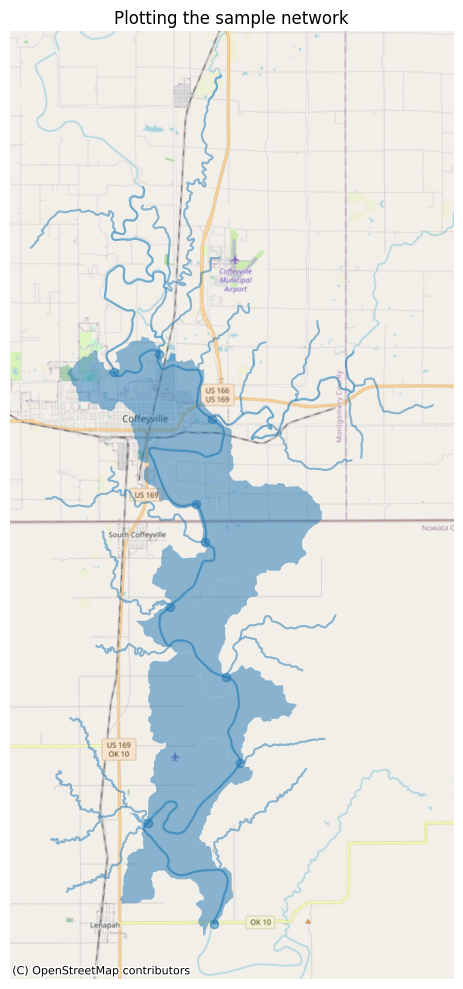

In [29]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the original data
_subset_nexus.plot(ax=ax, alpha=0.5)
_subset_flowlines.plot(ax=ax, alpha=0.5)
_subset_divides.plot(ax=ax, alpha=0.5)

cx.add_basemap(ax, crs=_subset_nexus.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

# Set the title and remove axis
plt.title('Plotting the sample network')
ax.axis('off')

# Display the plot
plt.tight_layout()
plt.show()

In [30]:
layers = fiona.listlayers("/Users/taddbindas/hydrofabric/v20.1/gpkg/nextgen_11.gpkg")
layers

['hydrolocations',
 'nexus',
 'flowpaths',
 'lakes',
 'divides',
 'network',
 'flowpath_attributes',
 'layer_styles']

In [31]:
output_divides = "/Users/taddbindas/projects/hydromt_sfincs/examples/tmp_ngwpc_data/coffeyville/flowlines_divides.geojson"
_subset_divides.to_file(output_divides, driver='GeoJSON')
_subset_divides.crs

<Projected CRS: EPSG:5070>
Name: NAD83 / Conus Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: Conus Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [32]:
# plt.figure(figsize=(20, 12))
# pos = nx.spring_layout(G, k=0.5, iterations=50)
# nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue')
# nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True)
# nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')
# plt.axis('off')
# plt.tight_layout()
# plt.show()
_obs = gpd.read_file("/Users/taddbindas/projects/hydromt_sfincs/examples/tmp_ngwpc_data/Central_US_Spring_2019.gpkg")
_obs = _obs.to_crs(epsg=5070)

intersection = gpd.overlay(_obs, subset, how='intersection')
intersection

,latitude_dd,longitude_dd,latitude,longitude,eventName,hwmTypeName,hwmQualityName,verticalDatumName,verticalMethodName,markerName,...,lon4326,adj_elev_ft,datum_offset_ft,HUC8,median_slope,missing_median_slope,freq_high_dev,missing_freq_high_dev,percent_covered_by_tiles,geometry
0,36.558930,-95.585730,36.558930,-95.585730,Central US Spring 2019,Debris,Good: +/- 0.10 ft,NAVD88,RT-GNSS,Stake,...,-95.585730,667.78,0.0,11070103,0.018635,False,0.001553,False,93.398251,POINT (36737.577 1501420.115)
1,36.566480,-95.602320,36.566480,-95.602320,Central US Spring 2019,Mud,Good: +/- 0.10 ft,NAVD88,RT-GNSS,Nail,...,-95.602320,667.38,0.0,11070103,0.018635,False,0.001553,False,93.398251,POINT (35262.841 1502259.604)
2,37.076322,-95.620705,37.076322,-95.620705,Central US Spring 2019,Seed line,Good: +/- 0.10 ft,NAVD88,Other (Note in Description box),Nail,...,-95.620705,727.16,0.0,11070103,0.018635,False,0.001553,False,93.398251,POINT (33404.682 1559374.748)
3,37.341409,-95.685529,37.341409,-95.685529,Central US Spring 2019,Stain line,Good: +/- 0.10 ft,NAVD88,Other (Note in Description box),Nail,...,-95.685529,779.73,0.0,11070103,0.018635,False,0.001553,False,93.398251,POINT (27597.326 1589059.071)
4,37.056550,-95.602330,37.056550,-95.602330,Central US Spring 2019,Other (Note in Description box),Good: +/- 0.10 ft,NAVD88,RT-GNSS,Nail,...,-95.602330,721.83,0.0,11070103,0.018635,False,0.001553,False,93.398251,POINT (35032.195 1557165.916)
5,37.061850,-95.602270,37.061850,-95.602270,Central US Spring 2019,Mud,Good: +/- 0.10 ft,NAVD88,RT-GNSS,Nail,...,-95.602270,722.01,0.0,11070103,0.018635,False,0.001553,False,93.398251,POINT (35034.996 1557759.809)
6,37.041680,-95.592300,37.041680,-95.592300,Central US Spring 2019,Seed line,Good: +/- 0.10 ft,NAVD88,None,Marker,...,-95.592300,721.38,0.0,11070103,0.018635,False,0.001553,False,93.398251,POINT (35922.917 1555503.471)
7,37.046280,-95.582830,37.046280,-95.582830,Central US Spring 2019,Debris,VP: > 0.40 ft,NAVD88,RT-GNSS,Paint,...,-95.582830,723.69,0.0,11070103,0.018635,False,0.001553,False,93.398251,POINT (36755.062 1556022.523)
8,37.004980,-95.601500,37.004980,-95.601500,Central US Spring 2019,Seed line,Good: +/- 0.10 ft,NAVD88,RT-GNSS,Nail,...,-95.601500,711.98,0.0,11070103,0.018635,False,0.001553,False,93.398251,POINT (35129.543 1551387.827)
9,36.985720,-95.594460,36.985720,-95.594460,Central US Spring 2019,Seed line,Good: +/- 0.10 ft,NAVD88,RT-GNSS,Nail,...,-95.594460,709.28,0.0,11070103,0.018635,False,0.001553,False,93.398251,POINT (35759.356 1549232.412)


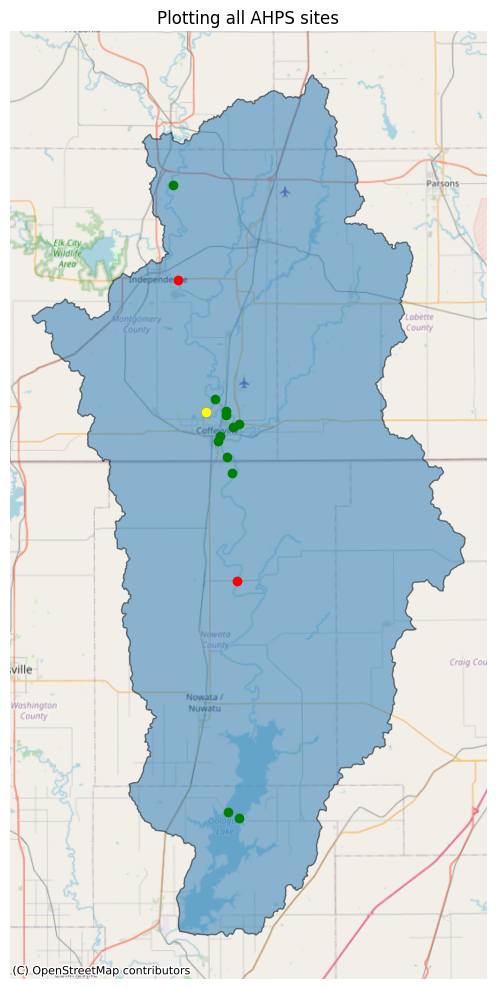

In [33]:
import matplotlib.pyplot as plt
import contextily as cx

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the original data
subset.plot(ax=ax, alpha=0.5, edgecolor='k')
intersection.plot(ax=ax, color='green', marker="o")

# Plot the bounding box
ahps_subset.plot(ax=ax, color='red')
ahps_lid.plot(ax=ax, color='yellow', marker="o")

cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

# Set the title and remove axis
plt.title('Plotting all AHPS sites')
ax.axis('off')

# Display the plot
plt.tight_layout()
plt.show()

### Step 1: Set up model

In [36]:
root = Path("/Users/taddbindas/projects/hydromt_sfincs/examples/tmp_ngwpc_data/")
yml_str = f"""
meta:
  root: {root.__str__()}
  
10m_lidar:
  path: HUC6_110701_dem.tiff
  data_type: RasterDataset
  driver: raster
  driver_kwargs:
    chunks:
      x: 6000
      y: 6000
  meta:
    category: topography
    crs: 5070
  rename:
    10m_lidar: elevtn
"""
data_lib = "tmp_data_catalogs/10m_huc6_lidar.yml"
with open(data_lib, mode="w") as f:
    f.write(yml_str)

In [37]:
# Initialize SfincsModel Python class with the artifact data catalog which contains publically available data for North Italy
# we overwrite (mode='w+') the existing model in the root directory if it exists
data_catalog = hydromt.DataCatalog(data_libs=[data_lib])
sf = SfincsModel(data_libs=["tmp_data_catalogs/10m_huc6_lidar.yml"], root="tmp_ngwpc_data", mode="w+")

### Step 2: Set up Grid

- This is the bounding box around the catchments of interest

In [38]:
sf.setup_grid_from_region(
    region = {'geom': 'tmp_ngwpc_data/coffeyville/flowlines_divides.geojson'},
    res= 50,
    rotated=True,
    crs=_subset_divides.crs  # NAD83 / Conus Albers HARDCODED TODO figure out making this cleaner
)
# the input file is automatically updated. Uncomment to displayed below:
print(sf.config)

{'mmax': 199, 'nmax': 499, 'dx': 50, 'dy': 50, 'x0': 32932.0, 'y0': 1533316.0, 'rotation': 5.758, 'latitude': 0.0, 'tref': datetime.datetime(2010, 2, 1, 0, 0), 'tstart': datetime.datetime(2010, 2, 1, 0, 0), 'tstop': datetime.datetime(2010, 2, 2, 0, 0), 'tspinup': 60.0, 'dtout': 3600.0, 'dthisout': 600.0, 'dtrstout': 0.0, 'dtmaxout': 86400, 'trstout': -999.0, 'dtwnd': 1800.0, 'alpha': 0.5, 'theta': 1.0, 'huthresh': 0.01, 'manning': 0.04, 'manning_land': 0.04, 'manning_sea': 0.02, 'rgh_lev_land': 0.0, 'zsini': 0.0, 'qinf': 0.0, 'rhoa': 1.25, 'rhow': 1024.0, 'dtmax': 60.0, 'advection': 1, 'baro': 0, 'pavbnd': 0, 'gapres': 101200.0, 'stopdepth': 100.0, 'crsgeo': 0, 'btfilter': 60.0, 'viscosity': 1, 'inputformat': 'bin', 'outputformat': 'net', 'cdnrb': 3, 'cdwnd': [0.0, 28.0, 50.0], 'cdval': [0.001, 0.0025, 0.0015], 'epsg': 5070}


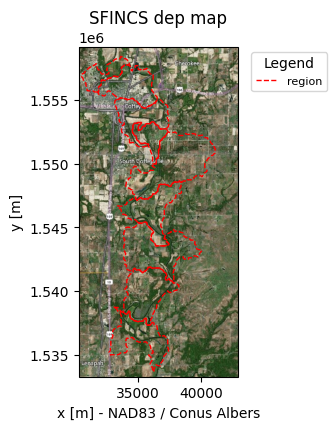

In [39]:
# show the model grid outline
# sf.region.boundary.plot(figsize=(6,6))
_ = sf.plot_basemap(plot_region=True, bmap="sat", zoomlevel=12)

### Step 3: Load in Elevation Data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


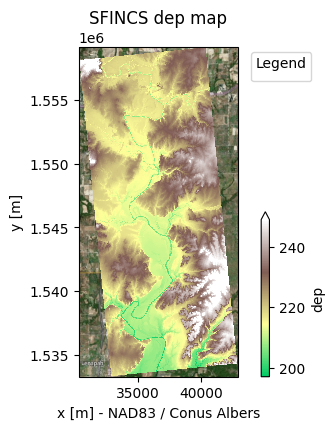

In [40]:
datasets_dep = [{"elevtn": "10m_lidar", "zmin": 0.001}]

# Add depth information to modelgrid based on these chosen datasets
dep = sf.setup_dep(datasets_dep=datasets_dep)

# Make a plot of the merged topobathy, here colour limits are set between an elevation of -5 to 5 meters
_ = sf.plot_basemap(variable="dep", bmap="sat", zoomlevel=12)

### Step 4: Mask active cells

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


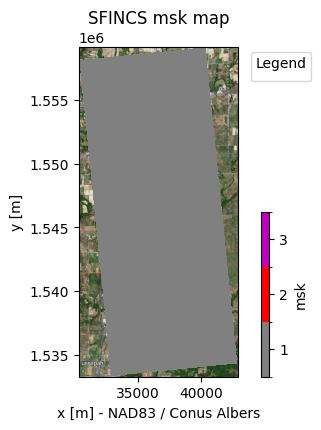

In [41]:
# Choosing how to choose you active cells can be based on multiple criteria, here we only specify a minimum elevation of -5 meters
sf.setup_mask_active(zmin=-5, reset_mask=True)

# Make a plot of the mask file
_ = sf.plot_basemap(variable="msk", plot_bounds=True, bmap="sat", zoomlevel=12)

### Step 5: Add output boundaries

<GeoAxes: title={'center': 'SFINCS msk map'}, xlabel='x [m] - NAD83 / Conus Albers', ylabel='y [m]'>

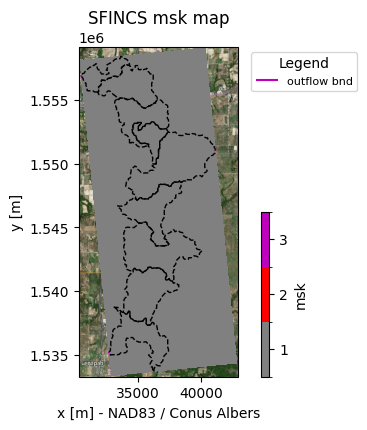

In [42]:
# file_name = "data//compound_example_outflow_boundary_polygon.geojson"
gdf_include = sf.data_catalog.get_geodataframe("tmp_ngwpc_data/coffeyville/flowlines_divides.geojson")

# Here we add water level cells along the coastal boundary, for cells up to an elevation of -5 meters
sf.setup_mask_bounds(btype="waterlevel", zmax=-5, reset_bounds=True)

# Here we add outflow cells, only where clicked in shapefile along part of the lateral boundaries
sf.setup_mask_bounds(btype="outflow", include_mask=gdf_include, reset_bounds=True)

# Make a plot of the mask file
fig, ax = sf.plot_basemap(variable="msk", plot_bounds=True, bmap="sat", zoomlevel=12)
gdf_include.to_crs(sf.crs).boundary.plot(
    ax=ax, color="k", lw=1, ls="--"
)  # plot the shapefile given by the user as dashed line

### Step 6: Add river inflow data

{'mmax': 199, 'nmax': 499, 'dx': 50, 'dy': 50, 'x0': 32932.0, 'y0': 1533316.0, 'rotation': 5.758, 'latitude': 0.0, 'tref': datetime.datetime(2010, 2, 1, 0, 0), 'tstart': datetime.datetime(2010, 2, 1, 0, 0), 'tstop': datetime.datetime(2010, 2, 2, 0, 0), 'tspinup': 60.0, 'dtout': 3600.0, 'dthisout': 600.0, 'dtrstout': 0.0, 'dtmaxout': 86400, 'trstout': -999.0, 'dtwnd': 1800.0, 'alpha': 0.5, 'theta': 1.0, 'huthresh': 0.01, 'manning': 0.04, 'manning_land': 0.04, 'manning_sea': 0.02, 'rgh_lev_land': 0.0, 'zsini': 0.0, 'qinf': 0.0, 'rhoa': 1.25, 'rhow': 1024.0, 'dtmax': 60.0, 'advection': 1, 'baro': 0, 'pavbnd': 0, 'gapres': 101200.0, 'stopdepth': 100.0, 'crsgeo': 0, 'btfilter': 60.0, 'viscosity': 1, 'inputformat': 'bin', 'outputformat': 'net', 'cdnrb': 3, 'cdwnd': [0.0, 28.0, 50.0], 'cdval': [0.001, 0.0025, 0.0015], 'epsg': 5070, 'depfile': 'sfincs.dep', 'mskfile': 'sfincs.msk', 'indexfile': 'sfincs.ind'}


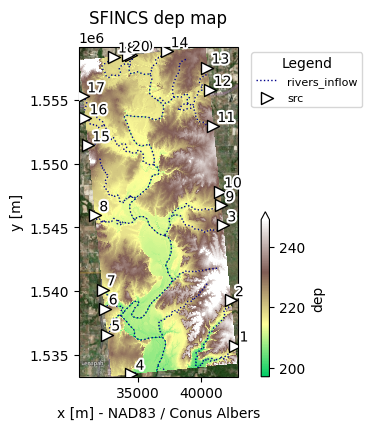

In [46]:
sf.setup_river_inflow(
    rivers=flowlines, keep_rivers_geom=True
)
print(sf.config)
# Make a plot of model
# note the src points and derived river network
fig, ax = sf.plot_basemap(variable="dep", plot_bounds=False, bmap="sat", zoomlevel=12)

In [49]:
# --> this is used when the making subgrid tables (step 8)

# use the derived rivers to burn these into the model subgrid
# note that the width and depth are arbitrary here

gdf_riv = sf.geoms["rivers_inflow"].copy()
gdf_riv["id"]
# gdf_riv["rivwth"] = [100, 50, 50]  # width [m]
# gdf_riv["rivdph"] = 1.5  # depth [m]
# gdf_riv["manning"] = 0.03  # manning coefficient [s.m-1/3]
# gdf_riv[["geometry", "rivwth", "rivdph", "manning"]]

# prepare the river dataset for the subgrid
# instead of using the derived rivers, you could also use an aribitrary shapefile with centerlines
# Other options include to add a river mask shapefile rather than a river width attribute
# Note that the width is either specified on the river centerline or with a river mask
# Also the river bed level (rivbed) can be specified instead of the river depth (rivdph).

# datasets_riv = [{"centerlines": gdf_riv}]



19081    wb-2175887
40171    wb-2176959
40170    wb-2176961
19524    wb-2176960
19523    wb-2176958
40166    wb-2176966
40160    wb-2175885
40159    wb-2176973
40158    wb-2175884
39680    wb-2178096
39671    wb-2176965
19080    wb-2175886
40165    wb-2176967
19526    wb-2176969
40164    wb-2176970
40157    wb-2176979
40156    wb-2176978
40144    wb-2175882
40145    wb-2176986
19531    wb-2176992
39681    wb-2178097
20180    wb-2178095
19079    wb-2175883
39675    wb-2178094
19078    wb-2175881
20153    wb-2178050
20152    wb-2178048
39699    wb-2178049
20154    wb-2178051
19546    wb-2177029
40143    wb-2176993
40121    wb-2175880
40142    wb-2176994
19530    wb-2176991
40141    wb-2176996
19077    wb-2175879
40119    wb-2177032
19548    wb-2177031
40118    wb-2177033
19076    wb-2175878
Name: id, dtype: object

### 7. Add spatially varying roughness data:

Not ready yet

### 8. Make subgrid derived tables:
Subgrid derived tables are used to better capture the elevation and roughness of your domain, to either improve your results, or to allow you to run on a courser grid resolution (means faster simulation). For more info about subgrid tables, [click here](https://sfincs.readthedocs.io/en/latest/developments.html#recent-advancements-in-accuracy-subgrid-mode). 

You as user can specify multiple settings about how the subgrid derived tables should be made.

Every single grid cell of the flux grid of the size inp.dx by inp.dy is defined into subgrid pixels (default nr_subgrid_pixels = 20).
For every subgrid pixel the topobathy data is loaded, ideally this consists of high-resolution DEM datasets that you specify as user.

In this example with dx=dy=50m, having nr_subgrid_pixels = 20 means we are loading data onto a 2.5 m subpixel grid
However, the input data of Gebco and Merit_hydro is way coarser, therefore let's set the ratio to 5 for now.

In [ ]:
sf.setup_subgrid(
    datasets_dep=datasets_dep,
    datasets_riv=datasets_riv,
    nr_subgrid_pixels=5,
    write_dep_tif=True,
    write_man_tif=False,
)

### 9. Add spatially varying infiltration data:

Not ready yet

### 10. Add water level time-series as forcing:

### 11. Add an upstream discharge time-series as forcing (NWM retrospective)

**a. specify discharge input locations: srcfile**

For more info about what the srcfile is, [click here](https://sfincs.readthedocs.io/en/latest/input_forcing.html#discharge-points)

**b. specify discharge time-series: disfile**

For more info about what the disfile is, [click here](https://sfincs.readthedocs.io/en/latest/input_forcing.html#discharge-time-series)

### 12. Add spatially varying rainfall data:

Not ready yet

### 13. Add weirfile:
In SFINCS, a weirfile is often used to explicity account for line-element features such as dikes, dunes or floodwalls. Read more about structures in the [SFINCS manual](https://sfincs.readthedocs.io/en/latest/input_structures.html)

### 14. Add observation points:

For more info about what the obsfile is, [click here](https://sfincs.readthedocs.io/en/latest/input.html#observation-points)

### 14. Add observation lines:

Observation lines (cross-sections) can be added to monitor discharges through cross-sections. For more info about what the crsfile is, [click here](https://sfincs.readthedocs.io/en/latest/input.html#cross-sections-for-discharge-output)

### 15. Show model:

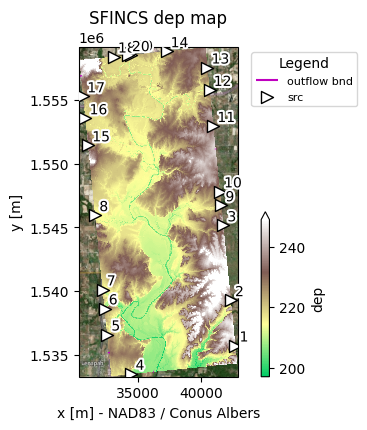

In [286]:
# Use predefined plotting function 'plot_basemap' to show your full SFINCS model setup
_ = sf.plot_basemap(fn_out="basemap.png", bmap="sat", zoomlevel=12)

### 16. Save all files

In [287]:
sf.write()  # write all
dir_list = os.listdir(sf.root)
print(dir_list)

['sfincs.dis', 'sfincs.dep', 'sfincs.msk', 'coffeyville', '.DS_Store', 'Central_US_Spring_2019.gpkg', 'hydromt.log', 'figs', 'boundaries.geojson', 'sfincs.src', 'upstream_location.gpkg', 'output_11070103.geojson', 'formatted-json-data.json', 'huc8s_sp.gpkg', 'build_hydrofabric.py', '2930769_subset.gpkg', 'hydromt_data.yml', 'HUC6_110701_dem.tiff', 'output_bbox_11070103.geojson', 'downstream_location.gpkg', 'sfincs.ind', 'nws_lid.gpkg', 'sfincs.inp', '01070006-nchn3-usgs.json', 'gis']
